How to Do Twitter Sentiment Analysis

Performing sentiment analysis on Twitter data involves several steps:

Get Twitter Data

Prepare Your Data

Create A Sentiment Analysis Model

Visualize The Results




In [47]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [48]:
!pip install gensim --upgrade

Requirement already up-to-date: gensim in /opt/conda/lib/python3.7/site-packages (3.8.3)


In [49]:
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

In [50]:
# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')


# Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Embedding
# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import collections
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [52]:
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
data = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv',encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

In [7]:
data.head(2)

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


In [8]:
data.sentiment.value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [9]:
data = data.drop(['ids', 'date', 'flag', 'user'], axis=1)

In [10]:
len(data)

1600000

In [11]:
decode = {0: "NEGATIVE",4: "POSITIVE"}
def decode_sentiment(label):
    return decode[int(label)]
data.sentiment = data.sentiment.apply(lambda x: decode_sentiment(x))

In [12]:
#decode sentiment 
data.sentiment.value_counts()

NEGATIVE    800000
POSITIVE    800000
Name: sentiment, dtype: int64

Text(0.5, 1.0, 'Dataset labels distrbution')

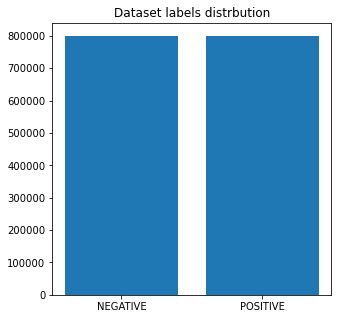

In [13]:
cont_sentiment=Counter(data.sentiment)
plt.figure(figsize=(5,5))
plt.bar(cont_sentiment.keys(),cont_sentiment.values())
plt.title('Dataset labels distrbution')

Preprocess the data

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [16]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [17]:
data.text = data.text.apply(lambda x: preprocess(x))

In [18]:
data.head(5)

,sentiment,text
0,NEGATIVE,awww bummer shoulda got david carr third day
1,NEGATIVE,upset update facebook texting might cry result...
2,NEGATIVE,dived many times ball managed save 50 rest go ...
3,NEGATIVE,whole body feels itchy like fire
4,NEGATIVE,behaving mad see


In [19]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [20]:
train, test = train_test_split(data, test_size=1-TRAIN_SIZE,
                                         random_state=0) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train))
print("Test Data size", len(test))

Train Data size: 1280000
Test Data size 320000


In [21]:
#word2evec
documents = [_text.split() for _text in train.text] 

In [22]:
w2v_model = gensim.models.word2vec.Word2Vec(size=300, 
                                            window=7, 
                                            min_count=10, 
                                            workers=8)

In [23]:
w2v_model.build_vocab(documents)

In [24]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30409


In [25]:
w2v_model.train(documents, total_examples=len(documents), epochs=15)

(123359842, 138423675)

In [32]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.text)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290574


In [33]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test.text),
                       maxlen = MAX_SEQUENCE_LENGTH)
print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [34]:
labels = train.sentiment.unique().tolist()

In [35]:
encoder = LabelEncoder()
encoder.fit(train.sentiment.to_list())

y_train = encoder.transform(train.sentiment.to_list())
y_test = encoder.transform(test.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [55]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2020-11-01 13:43:11--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-11-01 13:43:11--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-11-01 13:43:11--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [53]:
GLOVE_EMB = '/kaggle/working/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [56]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [58]:
embedding_matrix = np.zeros((vocab_size,EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [59]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [60]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [61]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [62]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
1250/1250 [==============================] - 830s 664ms/step - loss: 0.5193 - accuracy: 0.7393 - val_loss: 0.4816 - val_accuracy: 0.7658
Epoch 2/10
1250/1250 [==============================] - 836s 669ms/step - loss: 0.4876 - accuracy: 0.7623 - val_loss: 0.4710 - val_accuracy: 0.7729
Epoch 3/10
1250/1250 [==============================] - 838s 671ms/step - loss: 0.4774 - accuracy: 0.7692 - val_loss: 0.4667 - val_accuracy: 0.7761
Epoch 4/10
1250/1250 [==============================] - 835s 668ms/step - loss: 0.4711 - accuracy: 0.7732 - val_loss: 0.4631 - val_accuracy: 0.7784
Epoch 5/10
1250/1250 [==============================] - 839s 671ms/step - loss: 0.4665 - accuracy: 0.7760 - val_loss: 0.4608 - val_accuracy: 0.7797
Epoch 6/10
1250/1250 [==============================] - 832s 666ms/step - loss: 0.4633 - accuracy: 0.7777 - val_loss: 0.4592 - val_accuracy: 0.7804
Epoch 7/10
1250/1250 [==============================] - 830s 664ms/step - loss: 0.4604 - accuracy: 0.7797 - val_

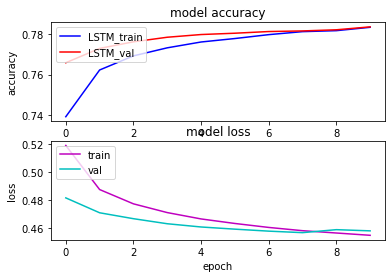

In [63]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [64]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 46s 1s/step
